<a href="https://colab.research.google.com/github/Asmaaad37/Computer-Vision/blob/main/The_Convolutional_Classifier%20-%201.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# The Convolutional Classifiers - By M.Asmaad Saeed
Let's build your first computer vision model with keras.

**First things first, let's understand what Computer Vision actually is ?**



*   Our goal would be to understand how a neural network can "understand" a natural image well-enough to solve the same kinds of problems the human "visual system" can solve.

*   The Neural Networks that are best at this task are called **Convolutionl Neural Networks** (Sometimes we refer to as convnet or CNN).

* ***Convolution*** is the mathematical operation that gives the layers of a *convnet* their unique structure.

**But What is an Image Classifier ??**
You might have seen apps that can classify/identify a species of plant form a photograph. That is exactly what an image classifier is !

Such that given a picture, can we train a computer to tell us what it's a picture of!!





# The Convolutional Classifier
A convnet used for image classification consists of two parts: a **convolutional base** and a **dense head**.


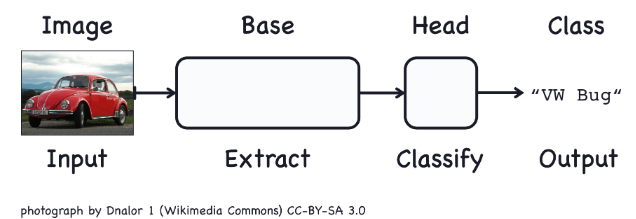

- The base is used to extract the features from an image. It is formed primarily of layers performing the convolution operation, but often includes other kinds of layers as well.

- The head is used to determine the class of the image. It is formed primarily of dense layers, but might include other layers like dropout.


**Visual feature ??**
 A feature could be a line, a color, a texture, a shape, a pattern -- or some complicated combination.

 We can assume the whole process goes something like:

 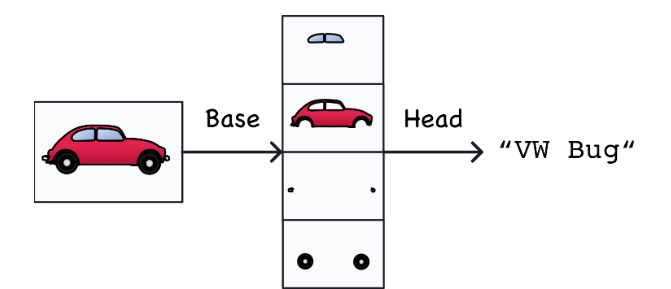

 The features actually extracted look a bit different, but it gives the idea

# Training the Classifier
The goal of the network during training is to learn two things:

1: which features to extract from an image (base),

2: which class goes with what features (head).


These days, convnets are rarely trained from scratch. More often, we ***reuse the base of a pretrained model***. To the pretrained base we then ***attach an untrained head***. In other words, we reuse the part of a network that has already learned to do

 1. Extract features, and attach to it some fresh layers to learn
 2. Classify.

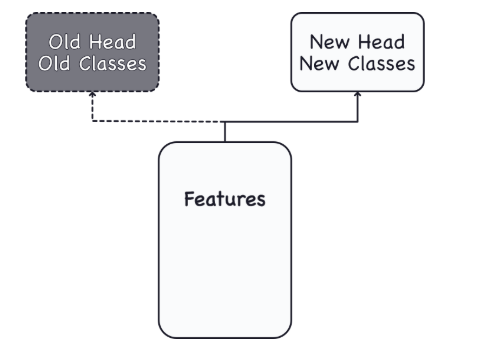

Because the head usually consists of only a few dense layers, very accurate classifiers can be created from relatively little data.

Reusing a pretrained model is a technique known as ***transfer learning***. It is so effective, that almost every image classifier these days will make use of it.

# Let's Begin with our Coding Section.

- For the purpose of simplicity i'm going to take a very simple dataset of *Cars and Trucks*, and we'll classify them : Is this a picture of a *Car* or of a *Truck* ?

Our Datset is about 10,000 pictures of various automobiles, around half cars and half trucks.

# **Step 1 - Load Data**

Now, before building our Image Classifier we have to select a pretrained base, we can choose from a large pool of bases that are available like e.g; **VGG16, InceptionV1 .. V4** etc.

Choosing the base is your own choice and you have to check whether you model is prone to overfitting or underfitting on your dataset.

I'll be using ***InceptionV1*** for this classifier.

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("ryanholbrook/car-or-truck")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/ryanholbrook/car-or-truck/versions/1


In [3]:
# Imports
import os, warnings
import matplotlib.pyplot as plt
from matplotlib import gridspec

import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory

# Reproducability
def set_seed(seed=31415):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
set_seed()


# Set Matplotlib defaults
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)
plt.rc('image', cmap='magma')
warnings.filterwarnings("ignore") # to clean up output cells


dataset_path = '/root/.cache/kagglehub/datasets/ryanholbrook/car-or-truck/versions/1'  # Update with the actual path where the data was saved.  This assumes the 'kagglehub' download put the dataset into a directory named 'car-or-truck' in the current directory.
train_path = os.path.join(dataset_path, "train")  # Build paths using os.path.join to be system independent
valid_path = os.path.join(dataset_path, "valid")



ds_train_ = image_dataset_from_directory(
    train_path,
    labels='inferred',
    label_mode='binary',
    image_size=[128, 128],
    interpolation='nearest',
    batch_size=64,
    shuffle=True,
)


ds_valid_ = image_dataset_from_directory(
    valid_path,
    labels='inferred',
    label_mode='binary',
    image_size=[128, 128],
    interpolation='nearest',
    batch_size=64,
    shuffle=False,
)

# Data Pipeline
def convert_to_float(image, label):
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    return image, label

AUTOTUNE = tf.data.experimental.AUTOTUNE
ds_train = (
    ds_train_
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)
ds_valid = (
    ds_valid_
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)

Found 5117 files belonging to 2 classes.
Found 5051 files belonging to 2 classes.


In [4]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("ryanholbrook/cv-course-models")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/ryanholbrook/cv-course-models/versions/4


In [5]:
import tensorflow_hub as hub
import tensorflow as tf

model_url = "/root/.cache/kagglehub/datasets/ryanholbrook/cv-course-models/versions/4/cv-course-models/inceptionv1"


# **Step 2 - Define Pretrained Base**

When doing ***transfer learning***, it's generally not a good idea to retrain the entire base -- at least not without some care. The reason is that the random weights in the head will initially create large *gradient* updates, which propogate back into the base layers and destroy much of the pretraining.

In [6]:
# trainable=False freezes the base model's weights
pretrained_base = hub.KerasLayer(model_url, trainable=False)

# **Step 3 - Attach Head**
Next, i'm going to attach the classsifier head. I'll use a layer of hidden units (the first `Dense` layer) followed by a layer to transform the outputs to a probability score of class 1, `Truck`. The `Flatten` layer transforms the two dimensional outputs of the base into the one dimensional inputs needed by the head.

In [7]:
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
    pretrained_base,
    layers.Flatten(),
    layers.Dense(6, activation='relu'),
    layers.Dense(1, activation='sigmoid'),
])



> *Before training a model in Keras, you need to specify an optimizer to perform the gradient descent, a loss function to be minimized, and (optionally) any performance metrics. The optimization algorithm i used is called "Adam", which generally performs well regardless of what kind of problem you're trying to solve.*

> *The loss and the metrics, however, need to match the kind of problem you're trying to solve. Our problem is a binary classification problem: Car coded as 0, and Truck coded as 1. Choose an appropriate loss and an appropriate accuracy metric for binary classification.*





# **Step 4 - Train**
Now, Comes the most exciting part -- **Training**. Since our model contains only two classes, i'll be using binary versions of `crossentropy` and `accuracy` and the `adam` optimizer generally performs well, so I'll use that!!

In [8]:
model.compile(
    optimizer = "adam",
    loss = "binary_crossentropy",
    metrics = ["binary_accuracy"]
)

# let's train our model
history = model.fit(
    ds_train,
    validation_data = ds_valid,
    verbose = 0,
    epochs = 10
)

# **Step 5 - Examine Loss and Accuracy**

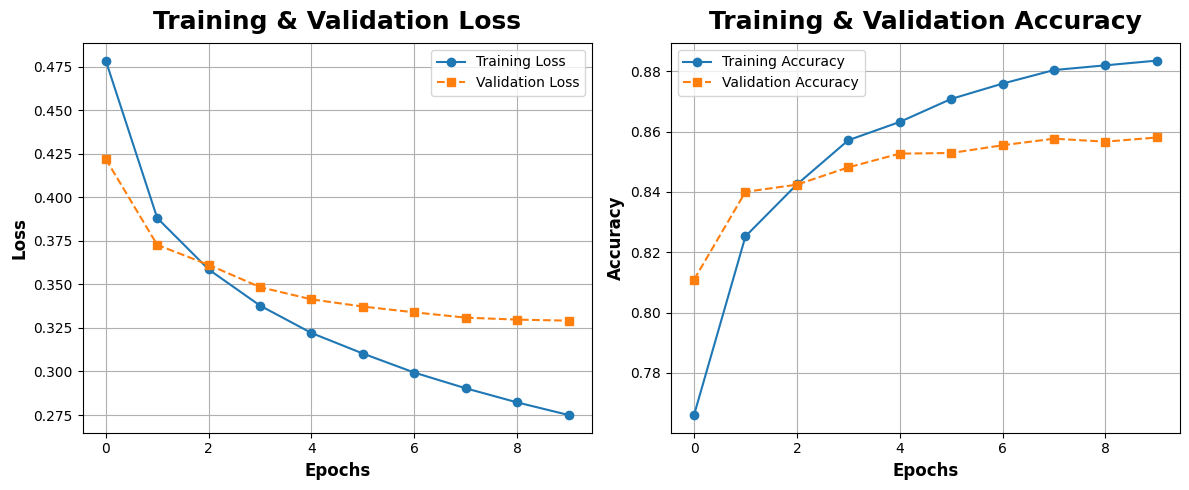

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

# Convert history to DataFrame
history_frame = pd.DataFrame(history.history)

# Set figure size
plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)  # Create first subplot
plt.plot(history_frame.index, history_frame['loss'], label='Training Loss', linestyle='-', marker='o')
plt.plot(history_frame.index, history_frame['val_loss'], label='Validation Loss', linestyle='--', marker='s')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()
plt.grid(True)

# Plot Accuracy
plt.subplot(1, 2, 2)  # Create second subplot
plt.plot(history_frame.index, history_frame['binary_accuracy'], label='Training Accuracy', linestyle='-', marker='o')
plt.plot(history_frame.index, history_frame['val_binary_accuracy'], label='Validation Accuracy', linestyle='--', marker='s')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training & Validation Accuracy')
plt.legend()
plt.grid(True)

# Show the plots
plt.tight_layout()
plt.show()


**Now upto you guys, what results can you conclude from these plot and why so ?**

# What we learned ?
 - The structure of a convnet classifier: a `head` to act as a classifier atop of a `base` which performs the feature extraction.

 - The head, essentially, is an ordinary classifier. For features, it uses those features extracted by the base. This is the basic idea behind **convolutional classifiers**: that we can attach a unit that performs feature engineering to the classifier itself.

 - This is one of the big advantages deep neural networks have over traditional machine learning models: given the right network structure, the deep neural net can learn how to engineer the features it needs to solve its problem.